# Data preparation and ingestion

In [1]:
# Imports
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
from elasticsearch import Elasticsearch
from statistics import median
from transformers import BigBirdModel, BigBirdTokenizer, LongformerTokenizer, LongformerModel
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

## Load the data

In [2]:
# Load in Pandas df
data_path = "../data/ancient_sources.csv.gz"
df = pd.read_csv(data_path, compression="gzip")
df.head()

,author,title,section,text
0,P. Ovidius Naso,The Epistles of Ovid,"Penelope to Ulysses, carte 53",Now corn grows where once Troy stood; and the ...
1,P. Ovidius Naso,Amores,"Liber Primus, ELEGIA 1","ELEGIA 1 Quemadmodum a Cupidine, pro bellis am..."
2,E.C. Marchant,Commentary on Thucydides: Book 7,"book 7, chapter 1, section 1",Ὁ —the art. added because this is a continuati...
3,E.C. Marchant,Commentary on Thucydides: Book 6,"book 6, chapter 1, section 1",ἐβούλοντο —‘the word is here (as in Xen. Hel. ...
4,E.C. Marchant,Commentary on Thucydides: Book 3,"book 3, chapter 1, section 1","θέρους —Thuc. divides the year into θέρος , co..."


In [3]:
# Check size
df.shape

(111752, 4)

## Data cleaning and EDA

In [4]:
# Append index as ID
df['Id'] = df.index

In [5]:
# Delete rows without text or section
df.drop(df[df["section"].isna()].index, inplace=True)
df.drop(df[df["text"].isna()].index, inplace=True)

In [6]:
# Check new size
df.shape

(85442, 5)

In [7]:
# Create a function that counts number of words of a text
def count_words(text):
    return len(text.split())

# Append a column with the number of words of the texts
df["num_words"] = df["text"].apply(count_words)

# Show first rows
df.head()

,author,title,section,text,Id,num_words
0,P. Ovidius Naso,The Epistles of Ovid,"Penelope to Ulysses, carte 53",Now corn grows where once Troy stood; and the ...,0,684
1,P. Ovidius Naso,Amores,"Liber Primus, ELEGIA 1","ELEGIA 1 Quemadmodum a Cupidine, pro bellis am...",1,287
2,E.C. Marchant,Commentary on Thucydides: Book 7,"book 7, chapter 1, section 1",Ὁ —the art. added because this is a continuati...,2,514
3,E.C. Marchant,Commentary on Thucydides: Book 6,"book 6, chapter 1, section 1",ἐβούλοντο —‘the word is here (as in Xen. Hel. ...,3,739
4,E.C. Marchant,Commentary on Thucydides: Book 3,"book 3, chapter 1, section 1","θέρους —Thuc. divides the year into θέρος , co...",4,50


In [8]:
df["num_words"].describe()

count    85442.000000
mean       173.797921
std        343.023254
min          1.000000
25%         58.000000
50%         92.000000
75%        163.000000
max      30158.000000
Name: num_words, dtype: float64

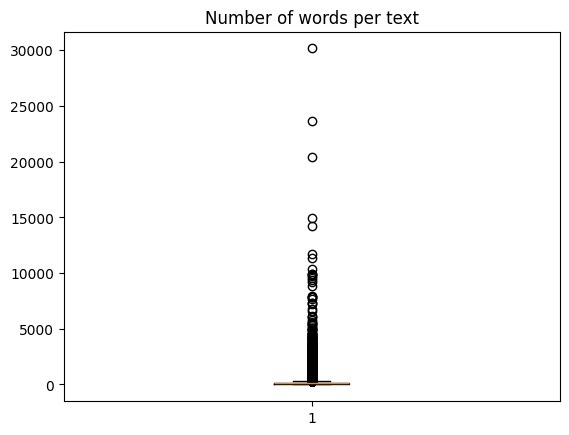

In [9]:
# Boxplot
boxplot_stats = plt.boxplot(df['num_words'])
plt.title('Number of words per text');

In [26]:
whiskers = [item.get_ydata() for item in boxplot_stats['whiskers']]
upp_whisker = whiskers[1][1]
print("Upper whisker:", upp_whisker)

Upper whisker: 320.0


In [31]:
df[df["num_words"] > 4000]

,author,title,section,text,num_words
1546,Flavius Josephus,The Wars of the Jews,"Book III, whiston chapter 7","[Note 1: VESPASIAN, WHEN HE HAD TAKEN THE CITY...",9411
1547,Flavius Josephus,Antiquities of the Jews,"book 5, whiston chapter 1","[Note 1: HOW JOSHUA, THE COMMANDER OF THE HEBR...",9213
1569,Flavius Josephus,Antiquities of the Jews,book 5,"[Note 1: HOW, AFTER THE DEATH OF JOSHUA THEIR ...",4255
1610,Flavius Josephus,The Wars of the Jews,Book III,[Note 1: HOW TARICHEAE WAS TAKEN. A DESCRIPTIO...,4213
1631,Flavius Josephus,The Wars of the Jews,", whiston chapter 1",[Note 1: THE SIEGE AND TAKING OF GAMALA] NOW a...,4063
...,...,...,...,...,...
79076,Celsus,De Medicina,Book VII,7 But whilst the preceding kinds of lesion do ...,5078
82615,Ammianus Marcellinus,"Rerum Gestarum, volume 1 introduction",book 1,Preface SOME of the reviews of my previous con...,11748
82807,Appian,The Civil Wars,", CHAPTER XI",CHAPTER XI Speeches of the Commanders -- Prepa...,4072
83208,Appian,The Civil Wars,BOOK III,CHAPTER VIII Antony orders Decimus Brutus to w...,4927


Although the limit stablished by boxplot is 320, we are not going to limit the length of the text. The BigBird (the model that we are going to use to generate the embbedings) tokenizer will truncate the texts that exceed the maximum context length (4096 tokens).

## Generate embeddings for vector search

In [10]:
# Transform into a list of dicts
# df_dict = df.to_dict(orient="records")

# Obtain list of texts
text_list = df["text"].tolist()

In [11]:
# Initialize tokenizer and model
model_name = "google/bigbird-roberta-base"
tokenizer = BigBirdTokenizer.from_pretrained(model_name)
model = BigBirdModel.from_pretrained(model_name)
model.eval();

/usr/local/python/3.12.1/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        return encoding


dataset = TextDataset(texts=text_list, tokenizer=tokenizer, max_length=4096)
dataloader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)

In [ ]:
all_embeddings = []

with torch.no_grad():
    for batch in tqdm(dataloader):
        inputs = {key: value.squeeze(1) for key, value in batch.items()}  # Remove batch dimension
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # Compute mean embedding
        all_embeddings.append(embeddings)

  0%|          | 0/10681 [00:00<?, ?it/s]